# Model fitting and robustness

In [1]:
%matplotlib inline

# Import packages and functions
import modelbase
import numpy as np
import pandas as pd
import os
import importlib
import sys
import re
import warnings

import matplotlib.pyplot as plt

from scipy.signal import find_peaks, savgol_filter
from scipy.integrate import simpson
from scipy.optimize import minimize

from modelbase.ode import Model, Simulator, mca

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from warnings import warn
from os import listdir
from os.path import join
from bisect import bisect_left
from datetime import datetime

# Helper functions
sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip
from module_update_FlvandCCM import CO2sol
from calculate_parameters_restruct import unit_conv

# Import model functions
from get_current_model import get_model
from module_update_phycobilisomes import add_OCP

idx = pd.IndexSlice

In [2]:
from functions_custom_steady_state_simulator import simulate_to_steady_state_custom

In [3]:
from functions_fluorescence_simulation import make_lights, make_adjusted_lights, create_protocol_NPQ, create_protocol_NPQ_short, create_protocol_noNPQ

## Settings

In [4]:
# Set the paths to save figures and objects
figure_path = Path("../Figures")
results_path = Path("../Results")

plot_format = ["svg", "png"]

# Reduce or increase the number of simulated points in appropriate analyses (1=default amount)
fraction_simulated_points = 0.3

In [5]:
integrator_kwargs = {
    "default": {
        "maxsteps": 10000,
        "atol": 1e-6,
        "rtol": 1e-6,
        "maxnef": 4,  # max error failures
        "maxncf": 1,  # max convergence failures
    },
    "retry": {
        "maxsteps": 20000,
        "atol": 1e-6,
        "rtol": 1e-6,
        "maxnef": 10, 
        "maxncf": 10
    },
}

In [6]:
# Define relative weights and normalisation factor for the residuals
residual_relative_weights = {
    'LET_fraction': 1,
    'LET_flux': 1,
    'Schuurmans_O2': 1,
    'Benschop_O2': 1,
    "PAMSP435_Fm'": 1,
    'PAMSP435_left': 1,
    'PAMSP435_right': 1,
    "PAMSPval_Fm'": 1,
    'PAMSPval_left': 1,
    'PAMSPval_right': 1
 }

residual_normalisation = {
    'LET_fraction': 0.0169,
    'LET_flux': 2.65,
    'Schuurmans_O2': 0.561,
    'Benschop_O2': 126.,
    "PAMSP435_Fm'": 0.0843,
    'PAMSP435_left': 0.0660,
    'PAMSP435_right': 0.0634,
    "PAMSPval_Fm'": 0.0910,
    'PAMSPval_left': 0.0964,
    'PAMSPval_right': 0.0985
 }

# Container for different residuals
residuals = {}

## Function definitions

In [7]:
def get_pathways_at_lights(model, y0, lights, intens):
    sims = []
    for i, light in zip(intens, lights):
        m = model.copy()
        m.update_parameter("pfd", light)

        # Prepare for ss simulation
        exch_dict = {
            "3PGA": {"k": 10, "thresh": 1000},
            # "PG": {"k": 10, "thresh": 1},
        }
        m =fnc.add_exchange(m, exch_dict)

        s = Simulator(m)
        s.initialise(y0)
        # t,y = s.simulate(10000)
        # t,y = s.simulate_to_steady_state(tolerance=1e-2)
        s,t,y = simulate_to_steady_state_custom(s,        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **integrator_kwargs["retry"])

        if t is None:
            raise RuntimeError(f"simulation failed for i={i:.2f}")
        else:
            sims.append(s)

    # Get the electron pathways
    pathways = pd.DataFrame({i:pd.DataFrame(fnc.get_ss_electron_pathways(s)).iloc[-1,:] for s,i in zip(sims, intens)}).T
    return pathways, sims

In [8]:
def get_O2andCO2rates(s):
    #  Get O2 and CO2 rates
    rates = {}
    res = {}

    rates["O2"] = fnc.get_stoichiometric_fluxes(s, "O2")
    rates["O2"].pop("vO2out")

    rates["CO2"] = fnc.get_stoichiometric_fluxes(s, "CO2")
    rates["CO2"].pop("vCCM")

    for cmp in ["O2", "CO2"]:
        prod = pd.DataFrame(rates[cmp].copy())
        prod[prod<0] = 0
        res[f"{cmp}_production"] = prod.sum(axis=1, skipna=False)

        cons = pd.DataFrame(rates[cmp].copy())
        cons[prod>0] = 0
        res[f"{cmp}_consumption"] = cons.sum(axis=1, skipna=False)

        res[f"{cmp}_net"] = pd.DataFrame(rates[cmp]).sum(axis=1, skipna=False)
    
    return pd.DataFrame(res)

In [9]:
def get_ssflux(m, y0, lightfun, target, light_params, tolerance=1e-4, rel_norm=False):
    light = lightfun(*light_params)
    s = Simulator(m.copy())
    s.update_parameter("pfd", light)
    s.initialise(y0)
    # t,y = s.simulate_to_steady_state(tolerance=tolerance, rel_norm=rel_norm, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **integrator_kwargs["retry"])
    if t is None:
        return np.nan
    else:
        return float(s.get_fluxes_dict()[target])

In [10]:
def get_best_peak(x, t_SP, **kwargs):
    """Get the best peaks height according to prominence.
    If none is found, return -1.

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """
    peaks = find_peaks(x, **kwargs)
    if len(peaks[0]) == 0:
        pos = None
    elif len(peaks[0]) == 1:
        if np.isnan(peaks[0][0]):
            pos = None
        else:
            pos = int(peaks[0][0])
    else:
        pos = int(peaks[0][np.argmax(peaks[1]["prominences"])])

    xmax = x.max()
    if pos is None:
        if ((x.loc[t_SP] - xmax) / xmax ) > 0.05:
            warn("strong deviance from max (> 5%)")
        return (-1, x.loc[t_SP])
    else:
        if ((x.iloc[pos] - xmax) / xmax ) > 0.05:
            warn("strong deviance from max (> 5%)")
        return (x.index[pos], x.iloc[pos])

In [11]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

In [12]:
def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,str(light)] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,str(growthlight)]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,str(growthlight)]), fraction_is_monomers=True, output_is_monomers=False)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    return res

def _plot_model_and_data(s, data, sim_offset=None, data_offset=None, ax=None):
    # Initialise a plot
    if ax is None:
        fig, ax = plt.subplots(**fnc.plt_defaults["figure"])
    else:
        fig = ax.figure

    # Align data and model using an offset
    if sim_offset is None:
        time = s.get_time()
    elif s.get_time()[0] != (-sim_offset):
        time = np.array(s.get_time())- (s.get_time()[0] + sim_offset)
    else:
        time = s.get_time()

    # Plot the data
    dat = data/data.max().max()
    dat_time = dat.index

    if data_offset is not None:
        dat_time -= data_offset
    dat_line = ax.plot(dat_time, dat.values, c="firebrick", label="Measurement")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Fluorescence [rel.]")
    ax.set_ylim(ymin=0)

    # Plot the simulation on top
    fluo = s.get_full_results_dict()["Fluo"]
    fluo_norm = fluo / fluo.max()
    sim_line = ax.plot(time, fluo_norm, c="black", label="Simulation")

    if len(dat_line)>1:
        handles = sim_line + dat_line[0]
    else:
        handles = sim_line + dat_line

    ax.legend(
        handles = handles,
        loc="center right",
        bbox_to_anchor = (1,0.85)
    )

    return fig, ax

def plot_model_and_data(s, data, pulse_pfd, ax=None, sim_offset=None, data_offset=None, **lightbar_kwargs):
    figs={}

    # Data plot
    col_select_kw = "^F"
    col_select = [i for i,x in enumerate(data.columns) if re.search(col_select_kw, x)]
    col_selectnam = data.columns[col_select]
    plot_data = data.loc[10:data.index[-1]-10, col_selectnam[:-1]]

    s_trim = fnc.remove_beginning_from_simulation(s, 300)

    fig,ax = _plot_model_and_data(s_trim, plot_data, sim_offset=sim_offset, data_offset=data_offset, ax=ax)
    ax = fnc.add_lightbar(s_trim, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, **lightbar_kwargs)

    return fig, ax

def annotate_electron_pathways(ax, epath):
    ypos = epath.cumsum(axis=1) - (epath/2)

    for y,s in zip(ypos.to_numpy().flatten(), epath.to_numpy().flatten()):
        ax.text(x=0, y=y, s=np.round(s,3), ha='center', va='center')
    return ax

def ss_analysis(m, light_int=100, light_wl=659):
    sslight = lip.light_gaussianLED(light_wl, light_int)
    mss = m.copy()
    mss.update_parameter("pfd", sslight)

    # Initialise the model
    sss=Simulator(mss)
    sss.initialise(y0)
    t,y = sss.simulate(10000)

    # plot_overview_isoATP(sss)
    epath = fnc.get_ss_electron_pathways(sss)
    epath = epath/float(epath.sum(axis=1, skipna=False))
    ax = epath.plot(kind="bar", stacked=True)

    # Annotate the bars
    ax = annotate_electron_pathways(ax,epath)
    return sss, [ax], epath

In [13]:
def complex_absorption(pfd, ps_ratio, pigment_content):
    absorption = lip.get_pigment_absorption(pigment_content)
    association = lip.get_pigment_association(
        ps_ratio,
        beta_carotene_method="stoichiometric",
        pigments=pigment_content,
        verbose=False,
    )

    M_chl = 893.509  # [g mol^-1] molar mass of chlorophyll a (C55H72MgN4O5)

    return (
        lip.get_complex_absorption(pfd, absorption, association) * M_chl
    )  # [µmol(Photons) mmol(Chl)^-1 s^-1]

## Data loading
Also selection of comparison points in the PAM-SP data

### Schuurmans O2 data

In [14]:
# Oxygen change rates from Schuurmans2014
Schuurmans = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0).loc[:,[" prod_625_highCO2", " cons_625_highCO2"]]
Schuurmans.columns = ["O2_production","O2_consumption"]

### Benschop O2 data

In [15]:
# Benschop O2 data
Benschop2003_low = pd.read_csv(Path("../Code/data/CO2fixation_Benschop2003_lowCO2.csv"), index_col=0)

# Conversion of µM Co2 concentration to partial pressure (atm)
# Assuming T=30°C, S=35 (Salinity of seawater)
T= 303.150 # [K]
S = 35 # [unitless] Salinity
CO2_conv = 1/(CO2sol(T,S,1) * 1e6)

Benschop_CO2uMs = Benschop2003_low.index.to_numpy()
Benschop_CO2pps = Benschop2003_low.index.to_numpy() * CO2_conv

### PAM-SP experiment with cells grown at 435nm light

In [16]:
# Get the fluorescence data paths
DIRPATH = Path("../Code/data")
PAMPATH = DIRPATH / "PAM_Slow_kinetics_files_Zavrel2021"
file_names = listdir(PAMPATH)
file_paths = np.array([join(PAMPATH, file_name) for file_name in file_names])

In [17]:
# Extract the measurement type from the file name, use to group replicates
meas_types = np.array([re.sub(r"([0-9]+)_[0-9]+\.[csvCSV]+", "\\1", x) for x in file_names])
meas_types_set = list(set(meas_types))
meas_types_set.sort()

In [18]:
# Load and preprocess all data
pamdata = {}

for meas_select in  meas_types_set:
    file_paths_select = file_paths[meas_types == meas_select]

    # Create a container for the combined data
    meas_data = pd.DataFrame([])

    # Iterate through the files
    for i,file_path in enumerate(file_paths_select):
        # Adapt the file reading parameters depending on the file structure
        if meas_select.startswith("PSI+PSII kinetics"):
            skiprows = 1
        else:
            skiprows = 0
        
        # Read the file and remove empty columns
        file_data = pd.read_csv(file_path, sep=";",skiprows=skiprows, index_col=0)
        file_data=file_data.loc[:,np.invert(np.all(np.isnan(file_data), axis=0))]

        if i == 0:
            # Save the common column names
            col_names = file_data.columns

        # Combine replicates
        meas_data = meas_data.join(file_data, rsuffix=f"_{i}", how="outer")

    # Exclude all data points that are nor present in all datasets
    excl_data = meas_data.iloc[list(np.invert(np.isnan(meas_data).any(axis=1))),:]
    excl_data.shape
        
    # Normalise the Data to its highest point
    norm_data = excl_data.copy()
    norm_data = norm_data / norm_data.max()

    # Set the normalised data as analysis data
    data = norm_data

    # # Calculate the mean over selected columns
    # for col_name in col_names:
    #     col_select = [bool(re.search(col_name, x)) for x in data.columns]
    #     col_mean = data.iloc[:,col_select].mean(axis=1, skipna=False).rename(f"{col_name}_mean")

    #     # Add to the dataframe
    #     data = data.join(col_mean)
    
    # Store the data
    pamdata[meas_select] = data

# Extract the growth lights
growthlights = set([re.sub("^.*([0-9]{3})$","\\1",meas_select) for meas_select in meas_types_set])

In [19]:

# Get the strain-specific parameters
dat = pd.read_csv(DIRPATH / "Strainparameters_Zavrel2021.csv", skiprows=1, index_col=0).iloc[:,2:]

# Get the concentration data
# dat_conc = dat.loc[dat.loc[:,"Unit"].str.match("fg cell-1"), :]
dat_conc = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
dat_conc.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']

# Convert to [mg mg(Chla)^-1]
dat_conc = dat_conc.div(dat_conc.iloc[0,:]) # convert to [mg mg(Chla)^-1]
dat_conc.loc[:,"Unit"] = "mg mg(Chla)^-1"

# Get the photosystems data
dat_PS = dat.loc[["PSI / PSII"],:]

# Get the phycobilisome data
dat_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
dat_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]


# Calculate the strain parameters
strain_params = {}
strain_export = {}

for growthlight in dat.columns:
    # Get the strain specific parameters
    strain_param = get_strain_parameters(
        df_pigments=dat_conc,
        df_PBS=dat_PBS,
        df_PS1_PS2=dat_PS,
        growthlight=growthlight,
        pbs_relfluo={"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    )

    MChl = 893.509 # [g mol^-1]
    absorption_coef_PAM435 = lip.get_pigment_absorption(strain_param["pigment_content"]).sum(axis=1) * MChl # [m^2 mmol(Chl)^-1]

    # Get the PAM sample Chl concentration
    # Estimated from a later measurement where OD600 = 0.8, the PAM samples had 0.6
    OD800_Chlconc = pd.read_excel(DIRPATH/"Chlorophyll, total car.xlsx", skiprows=1).iloc[1:,].loc[:,["Sample", "Chlorophyll a"]]
    OD800_Chlconc.loc[:,"Sample"] = OD800_Chlconc.loc[:,"Sample"].str.removesuffix(" nm")
    OD800_Chlconc = OD800_Chlconc.groupby("Sample").mean()
    OD800_Chlconc.head() # [mol (10 ml)^-1]

    indexmapping = {idx1:idx2 for idx1,idx2 in zip(dat.columns, OD800_Chlconc.index)}

    # Convert the chlorophyll concentration units
    cuvette_Chlconc_PAM435 = ( # [mmol(Chl) m^-3]
        float(OD800_Chlconc.loc[indexmapping[str(growthlight)]]) # [mol (10 ml)^-1]
        / 10 # [ml]
        * 1e3 # [mol mmol^-1]
        * 1e6 # [ml m^-3]
        * 0.3 / 0.8 # [rel] OD of the PAM sample
    )

    # Save the data
    strain_params[growthlight] = {
        "params": strain_param,
        "cuvette_Chlconc": cuvette_Chlconc_PAM435,
        "absorption_coef": absorption_coef_PAM435,
    }

#### Select the PAM data

In [20]:
# Select the experiment to use and the range in which to search for the SPs
experiment_select = 'PSII kinetics, NPQ at state 1_435'
peak_find_range = np.array([-5, +5])

pamdata_select = pamdata[experiment_select]

#### Find the FM's

In [21]:
# Container for storing Fm' and Fs values
data_points_435 = {}

In [22]:
# Define the timings of the expected Fm's
# An SP is given every 20 seconds
Fm_timings = np.arange(13, pamdata_select.index[-1], 20)[:-1]

In [23]:
# Make containers for recording the peak values and times
_peaks = pd.DataFrame(
    np.nan,
    index=Fm_timings,
    columns=pamdata_select.columns)
_peak_times=_peaks.copy()

for i, t_SP in enumerate(Fm_timings):
    # Select the region around the expected SP time
    _peak = (pamdata_select
        .ffill(axis=0) # remove NAs     
        .apply(savgol_filter, window_length=10, polyorder=2) # Smooth the signal
        .loc[slice(*(t_SP+peak_find_range)),:]
        .apply(get_best_peak, t_SP=t_SP, width=15, prominence=0.005, axis=0) # plateau_size=10,
        ) # Find peaks
    _peak_times.loc[t_SP] = _peak.iloc[0,:].to_numpy()
    _peaks.loc[t_SP] = _peak.iloc[1,:].to_numpy()

data_points_435["Fm'"] = _peaks

#### Select values left and right of the FM'

In [24]:
# Get the maximal distance between the detected expected timing of Fms
# The selected next to the
# _peak_times.subtract(Fm_timings, axis=0).abs().max()

In [25]:
# Select points left and right of the SP
point_timing = (-3, +3)

data_points_435["left"] = pamdata_select.loc[Fm_timings + point_timing[0]]
data_points_435["right"] = pamdata_select.loc[Fm_timings + point_timing[1]]

### PAM-SP validation experiment

In [26]:
df = pd.read_csv(Path("../Code/data/PAM_validation_Zavrel2024.csv"), index_col=[0], header=[0,1,2])
pamdata_select = df.loc[:1126,idx["25", "white",:]]

#### Find the FM's

In [27]:
# Container for storing Fm' and Fs values
data_points_val = {}

In [28]:
# Define the timings of the expected Fm's
# An SP is given every 30 seconds
Fm_timings = np.arange(13, pamdata_select.index[-1], 30)

In [29]:
# Make containers for recording the peak values and times
_peaks = pd.DataFrame(
    np.nan,
    index=Fm_timings,
    columns=pamdata_select.columns)
_peak_times=_peaks.copy()

for i, t_SP in enumerate(Fm_timings):
    # Select the region around the expected SP time
    _peak = (pamdata_select
        .ffill(axis=0) # remove NAs     
        .apply(savgol_filter, window_length=10, polyorder=2) # Smooth the signal
        .loc[slice(*(t_SP+peak_find_range)),:]
        .apply(get_best_peak, t_SP=t_SP, width=15, prominence=0.005, axis=0) # plateau_size=10,
        ) # Find peaks
    _peak_times.loc[t_SP] = _peak.iloc[0,:].to_numpy()
    _peaks.loc[t_SP] = _peak.iloc[1,:].to_numpy()

data_points_val["Fm'"] = _peaks

#### Select values left and right of the FM'

In [30]:
# Get the maximal distance between the detected expected timing of Fms
# The selected next to the
# _peak_times.subtract(Fm_timings, axis=0).abs().max()

In [31]:
# Select points left and right of the SP
point_timing = (-3, +3)

data_points_val["left"] = pamdata_select.loc[Fm_timings + point_timing[0]]
data_points_val["right"] = pamdata_select.loc[Fm_timings + point_timing[1]]

# Modelling

## 1) Electron pathways at different light intensities
Target: 15 electrons/PSI/s LET amounting to ~65%

In [32]:
# Measure the time needed for a singe run
start_time = datetime.now()

In [33]:
normToPS1 = True

intens = np.linspace(100, 320, int(10 * fraction_simulated_points))
lights = [lip.light_gaussianLED(670, i) for i in intens]

# Simulate Wild Type and different mutants
# Standard model
m,y0 = get_model(check_consistency=False, verbose=False)

pathways, sims = get_pathways_at_lights(m, y0, lights, intens)
# fnc.save_Simulator_dated(sims, f"resid_epaths_sims", results_path)
# fnc.save_obj_dated(pathways, "resid_epaths_paths", results_path)

# Get the mean LET fraction
let_frac = (pathways.T / pathways.sum(axis=1)).T["linear"]

# Residuals with target value 65%
residuals["LET_fraction"] = np.linalg.norm(let_frac - 0.65, ord=2)

# Get the Let flux per PSI
norm = m.get_parameter("PSItot") *3# Normalise to PS1 monomers
let_flux = pathways["linear"].iloc[-1] / norm

# Residuals with target value 65%
residuals["LET_flux"] = np.abs(let_flux - 15)

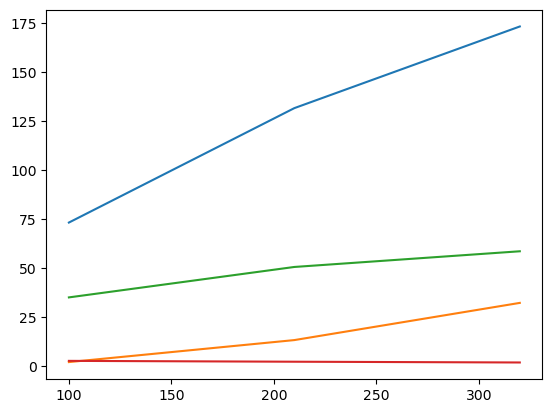

In [34]:
# Set up a figure with all axes shared but the last one
models = {"m0":m}
sims = {"m0":sims}
pathways = {"m0":pathways}

# Plot all
titles = {
    "m0":"WT",
    "mFlv":"$\it{Flv1/3}$",
    "mNQ": "$\it{NDH}$-$\it{1}$",
    "mCO2": "Air CO$_2$"
}

fig = plt.figure()
axes = np.full(len(titles)+1,0, dtype=object)
axes[0] = fig.add_subplot(1,len(titles)+1,1)
for i in range(2,len(titles)+2):
    axes[i-1] = fig.add_subplot(1,len(titles)+1,i, sharey=(axes[0] if i!=5 else None))

fig.set_size_inches(12,3.5)

# Line Plot
for (key, ptw), ax in zip(pathways.items(), axes):
    norm = m.get_parameter("PSItot") *3 if normToPS1 else 1 # Normalise to PS1 monomers
    ptw_norm = ptw / norm
    vps2 = pd.Series([s.get_fluxes_df().loc[:,"vPS2"].iloc[-1] for s in sims[key]], index=intens) * 2 / norm

    lin = ax.plot(ptw_norm)
    lin2 = ax.plot(vps2, c="k", label = "PS2 flux")

for (key, ptw), ax in zip(pathways.items(), axes):
    ax.text(0, ax.get_ylim()[1]*0.93, titles[key] + (" (fitted)" if key == "m0" else ""))

if normToPS1:
    axes[0].set_ylabel("Pathway electron flux [e$^-$ PSI$^{-1}$ s$^{-1}$)]")
else:
    axes[0].set_ylabel("Pathway electron flux [mmol(e$^-$) mol(Chl)$^{-1}$ s$^{-1}$)]")

axes[2].set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
axes[2].legend(
        handles=lin2 + lin,
        labels=["Flux from PSII", "Linear", "Alternate", "Cyclic", "Respiratory"], 
        loc="center",
        bbox_to_anchor= (0.5, 1.07),
        borderaxespad= 0,
        ncol=5
        )

# Calculate mean pathway usage
pathway_mean = {}
pathway_sd = {}

for mdl in pathways.keys():
    pathway_mean[mdl] = (pathways[mdl].loc[10:,:].T / pathways[mdl].sum(axis=1)).T.mean(axis=0)
    pathway_sd[mdl] = (pathways[mdl].loc[10:,:].T / pathways[mdl].sum(axis=1)).T.std(axis=0)

pathway_mean = pd.DataFrame(pathway_mean)
pathway_sd = pd.DataFrame(pathway_sd)

# Create a container for the y errors
yerr = [[row, row] for i,row in pathway_sd.iterrows()]

pathway_mean.T.plot.bar(stacked=True, yerr=yerr, ax=axes[-1])

# Remove the legend
axes[-1].get_legend().remove()

# Set the y axis to the right
axes[-1].yaxis.set_label_position("right")
axes[-1].yaxis.tick_right()
axes[-1].set_ylabel("Proportion of total electron flux at\nlight > 10 µmol(Photons) m$^{-2}$ s$^{-1}$ [rel.]")

axes[-1].set_xticklabels([titles[x] for x in pathway_mean.columns], rotation=30, ha="right", rotation_mode='anchor')

fig.tight_layout()
fnc.savefig_dated(fig, f"electronpaths-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")

## 2) Schuurmans Oxygen and CO2 fluxes (Figure 6)

In [34]:
# Define the simulated lights
intens = Schuurmans.index.to_numpy()
lights = [lip.light_gaussianLED(625, i) for i in intens]

# Standard model
m,y0 = get_model(check_consistency=False, verbose=False)

# Adjust the lights to in-culture conditions (2 mg(Chl) l^-1 according to Schuurmans)
MChl = 893.509 # [g mol^-1]
absorption_coef_Schuurmans = lip.get_pigment_absorption(m.parameters["pigment_content"]).sum(axis=1) * MChl
lights = lip.get_mean_sample_light(
    lights, # [µmol(Photons) m^-2 s^-1]
    depth = 0.01,  # [m]
    absorption_coef=absorption_coef_Schuurmans,
    chlorophyll_sample=(
        2 # [mg(Chl) l^-1] (Schuurmans2014)
        / MChl # [mol g^-1]
        * 1e3
    ) # [mmol(Chl) m^-3]
)

# If a lower fraction of simulated points is given, select fewer points
if fraction_simulated_points <1:
    lights_select = slice(0,len(lights), int(fraction_simulated_points**-1))
else:
    lights_select = slice(None)
# Calculate the pathways for the specified lights
pathways, sims = get_pathways_at_lights(m, y0, lights[lights_select], intens[lights_select])

# Get the O2 and CO2 rates for Wild Type
gasrates = pd.concat([get_O2andCO2rates(s).iloc[-1,:] for s in sims], axis=1)
gasrates.columns = intens[lights_select].astype(int)
# fnc.save_obj_dated(gasrates, "resid_Schuurmans_gasrates", results_path)

# Calculate the Root mean squared error (RMSE)
res = gasrates.T.loc[:, ["O2_production","O2_consumption"]] * prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"])
res = res - Schuurmans.loc[res.index,:]
residuals["Schuurmans_O2"] = (res**2).mean().mean()**0.5


## 3) Benschop O2 data

In [35]:
# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

# If a lower fraction of simulated points is given, select fewer points
if fraction_simulated_points <1:
    CO2_select = slice(0,len(Benschop_CO2pps), int(fraction_simulated_points**-1))
else:
    CO2_select = slice(None)

O2s = pd.Series(np.nan, index=Benschop_CO2uMs[CO2_select])
for CO2pp, CO2uM in zip(Benschop_CO2pps[CO2_select], Benschop_CO2uMs[CO2_select]):
    m_MCA.update_parameters({
        "CO2ext_pp": CO2pp,
    })

    _O2s = get_ssflux(
        m_MCA,
        y0,
        lip.light_spectra,
        "vO2out",
        ("cool_white_led", 800),
    )

    O2s.loc[CO2uM] = _O2s

# fnc.save_obj_dated(O2s, "resid_Benschop_O2", results_path)

# Calculate the Root mean squared error (RMSE)
res = O2s * unit_conv(['mmol mol(Chl)-1 -> mmol g(Chl)-1', 's-1 -> h-1'])
res = res - Benschop2003_low.iloc[CO2_select,0]
residuals["Benschop_O2"] = (res**2).mean()**0.5

## 4) Original 435 nm PAM-SP experiment

### Get the PAM and strain data

### Model the data

In [36]:
# Container for the simulated points
sim_points = pd.DataFrame(np.nan, index=data_points_435["Fm'"].index, columns=["Fm'", "left", "right"])

### Simulate the 435 nm experiment (with low blue phase after red)

In [37]:
# Select the measurement to simulate
growthlight = int(experiment_select[-3:])

strain_param = strain_params[str(growthlight)]["params"]
cuvette_Chlconc_PAM435 = strain_params[str(growthlight)]["cuvette_Chlconc"]

# Get the latest model version
m4,y0 = get_model(check_consistency=False, reduced_size=False, verbose=False)

# ADAPTION TO THE STRAIN
y0.update({"PSII":strain_param["PSIItot"]})
m4.update_parameters(
    strain_param
)

# Change the CO2 concentration to 400ppm as experiments were conducted in air
m4.update_parameter("CO2ext_pp", 0.0004)

# Initialise the model
s_435=Simulator(m4)
s_435.initialise(y0)

# Simulate the appropriate protocol
pulse_pfdm4 = 2600 * 2
lights_lowpulse = make_adjusted_lights(
    absorption_coef=absorption_coef_PAM435, 
    chlorophyll_sample=cuvette_Chlconc_PAM435, 
    lights=make_lights(pulseInt=pulse_pfdm4, blue_wl=480)
)
if experiment_select.startswith("PSII kinetics, NPQ at state 2"):
    protocol_435 = create_protocol_noNPQ(*lights_lowpulse)
else:
    protocol_435 = create_protocol_NPQ(*lights_lowpulse)

s_435 = fnc.simulate_protocol(
    s_435, 
    protocol_435, 
    retry_unsuccessful=True,
    retry_kwargs=integrator_kwargs["retry"],
    n_timepoints=10,
    **integrator_kwargs["default"]
)

Retrying with retry_kwargs... success


In [38]:
# Determine the Fm' timings (SP pulses have intensity > 2000)
SP_bool = (protocol_435.loc[:,protocol_435.columns.str.startswith("_light")].apply(simpson, axis=1) > 2000).to_numpy()

SP_times = pd.DataFrame({
    "start": protocol_435.iloc[:-1].loc[SP_bool[1:], "t_end"].to_numpy(), 
    "end": protocol_435.loc[SP_bool, "t_end"].to_numpy()
})

In [39]:
# Get the simulated fluorescence normalized to 1
fluo = s_435.get_full_results_df()["Fluo"]
fluo = fluo / fluo.max()

In [40]:
# Get the respective values from the simulated data
for i, (start, end) in SP_times.iterrows():
    peak_time = fluo.loc[start:end].idxmax()
    
    # Get the FM' value and values to the left and right
    sim_points.iloc[i,0] = fluo.loc[peak_time]

    for j, offset in enumerate(point_timing):
        point_time = peak_time + offset
        nearest_time = bisect_left(fluo.index, point_time)
        sim_points.iloc[i,j+1] = fluo.loc[fluo.index[[nearest_time, nearest_time+1]]].mean()

In [41]:
# Calculate the residuals for all three points
for col in sim_points.columns:
    residuals[f"PAMSP435_{col}"] = (
        (data_points_435[col]
        .subtract(sim_points[col].to_numpy(),axis=0)
        **2)
        .mean()
        **(0.5)
        ).mean()

## 5) Validation PAM-SP experiment

In [42]:
# Container for the simulated points
sim_points = pd.DataFrame(np.nan, index=data_points_val["Fm'"].index, columns=["Fm'", "left", "right"])

In [43]:
# Protocol of the validation experiment
dark, low_blue, high_blue, orange, pulse_orange, pulse_blue = make_lights(
    blueInt=80,
    orangeInt=50,
    highblueInt=1800,
    pulseInt=15000,
    orange_wl=625,
    blue_wl=440,
)
pulse_white = lip.light_spectra("cool_white_led", 15000)


# Dark acclimation
protocol_val = fnc.create_protocol_const(
    light=dark,
    time=300
)

# Dark phase
protocol_val = fnc.create_protocol_PAM(
    init=protocol_val,
    actinic=(dark, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=4,
    final_actinic_time=5
)

# Blue phase
protocol_val = fnc.create_protocol_PAM(
    init=protocol_val,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Orange phase
protocol_val = fnc.create_protocol_PAM(
    init=protocol_val,
    actinic=(orange, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
    first_actinic_time=25,
    final_actinic_time=5,
)

# Blue phase
protocol_val = fnc.create_protocol_PAM(
    init=protocol_val,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# High blue phase
protocol_val = fnc.create_protocol_PAM(
    init=protocol_val,
    actinic=(high_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Blue phase
protocol_val = fnc.create_protocol_PAM(
    init=protocol_val,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Simulate the validation experiment
m,y0 = get_model(verbose=False, check_consistency=False)
s_val = Simulator(m)
s_val.initialise(y0)

# The culture is grown under 1% CO2
s_val.update_parameter("CO2ext_pp", 0.01)

s_val = fnc.simulate_protocol(
    s_val, 
    protocol_val, 
    retry_unsuccessful=True,
    retry_kwargs=integrator_kwargs["retry"],
    n_timepoints=10,
    **integrator_kwargs["default"]
)

In [44]:
# Determine the Fm' timings (SP pulses have intensity > 2000)
SP_bool = (protocol_val.loc[:,protocol_val.columns.str.startswith("_light")].apply(simpson, axis=1) > 2000).to_numpy()

SP_times = pd.DataFrame({
    "start": protocol_val.iloc[:-1].loc[SP_bool[1:], "t_end"].to_numpy(), 
    "end": protocol_val.loc[SP_bool, "t_end"].to_numpy()
})

In [45]:
# Get the simulated fluorescence normalized to 1
fluo = s_val.get_full_results_df()["Fluo"]
fluo = fluo / fluo.max()

In [46]:
# Get the respective values from the simulated data
for i, (start, end) in SP_times.iterrows():
    peak_time = fluo.loc[start:end].idxmax()
    
    # Get the FM' value and values to the left and right
    sim_points.iloc[i,0] = fluo.loc[peak_time]

    for j, offset in enumerate(point_timing):
        point_time = peak_time + offset
        nearest_time = bisect_left(fluo.index, point_time)
        sim_points.iloc[i,j+1] = fluo.loc[fluo.index[[nearest_time, nearest_time+1]]].mean()

In [47]:
# Calculate the residuals for all three points
for col in sim_points.columns:
    residuals[f"PAMSPval_{col}"] = (
        (data_points_val[col]
        .subtract(sim_points[col].to_numpy(),axis=0)
        **2)
        .mean()
        **(0.5)
        ).mean()

## Calculate the total residuals

In [48]:
residual_weights = pd.Series(residual_normalisation) * pd.Series(residual_relative_weights)

In [49]:
residual = (pd.Series(residuals) / residual_weights).mean()

In [50]:
(pd.Series(residuals) / residual_weights)

LET_fraction      1.001847
LET_flux          0.999418
Schuurmans_O2     1.000548
Benschop_O2       1.006134
PAMSP435_Fm'      0.999955
PAMSP435_left     1.000631
PAMSP435_right    1.000220
PAMSPval_Fm'      0.999808
PAMSPval_left     1.000153
PAMSPval_right    1.000400
dtype: float64

In [51]:
residual

1.0009113178610527

In [52]:
end_time = datetime.now()
print(f"total time: {(end_time - start_time)}")

total time: 0:02:43.268139
